In [17]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('negative_samples_within_polygons_updated.csv')

df["species"] = "None"
# Remove rows containing NaN values
df_cleaned = df.dropna()

# If you want to reset the index after dropping rows
df_cleaned.reset_index(drop=True, inplace=True)

# Print the cleaned DataFrame
print(df_cleaned)


    species                                  location          observed_on  \
0      None  (41.860549086379336, -3.997153418273683)  2011-06-04 00:00:00   
1      None   (39.77892001761015, -5.855222859449896)  2022-09-20 00:00:00   
2      None   (37.18948622230711, -4.309480117849915)  2022-08-21 00:00:00   
3      None    (28.8924438647564, -13.76806464598343)  2016-07-05 00:00:00   
4      None   (43.10592567263507, -8.253206129071685)  2012-12-06 00:00:00   
..      ...                                       ...                  ...   
298    None  (41.90462528142555, -0.9090131694325407)  2015-09-25 00:00:00   
299    None  (40.70329489717011, -0.6702726252463265)  2022-10-16 00:00:00   
300    None   (38.85999097093432, -6.559134679566256)  2018-01-19 00:00:00   
301    None  (40.527571422285206, -0.720563888481422)  2021-04-07 00:00:00   
302    None  (40.89040677000051, -3.4544445352178457)  2014-01-27 00:00:00   

        P_1     P_2     P_3     P_4     P_5     P_6     P_7  ..

In [18]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Load the GeoJSON file containing the polygon of Spain
spain_polygon = gpd.read_file('spain.geojson')

# Load the CSV file into a DataFrame
df = df_cleaned

# Extract latitude and longitude from the "location" column
df[['latitude', 'longitude']] = df['location'].str.extract(r'\(([^,]+),([^)]+)\)').astype(float)

# Drop the original "location" column
df.drop(columns=['location'], inplace=True)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Ensure that both GeoDataFrames have the same CRS (Coordinate Reference System)
gdf.crs = spain_polygon.crs

# Perform a spatial join to keep only the points inside the polygon
points_inside_polygon = gpd.sjoin(gdf, spain_polygon, op='within')

# Drop unnecessary columns added during the join
points_inside_polygon.drop(columns=['index_right'], inplace=True)
points_inside_polygon
# Save the filtered points to a new CSV file
#points_inside_polygon.to_csv('points_inside_spain.csv', index=False)


/home/federico/.pyenv/versions/3.8.8/envs/fungi/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,species,observed_on,P_1,P_2,P_3,P_4,P_5,P_6,P_7,P_8,...,Tmin_14,latitude,longitude,geometry,cod_prov,name,cod_ccaa,cartodb_id,created_at,updated_at
0,None,2011-06-04 00:00:00,0.1875,3.0000,1.0625,0.9375,0.0625,0.8125,0.3750,0.3750,...,26.0625,41.860549,-3.997153,POINT (-3.99715 41.86055),07,Illes Balears,03,7,2014-09-30,2014-12-25 01:56:10
1,None,2022-09-20 00:00:00,0.1875,0.3750,0.3750,0.1875,1.2500,0.7500,0.3750,0.2500,...,24.2500,39.778920,-5.855223,POINT (-5.85522 39.77892),07,Illes Balears,03,7,2014-09-30,2014-12-25 01:56:10
2,None,2022-08-21 00:00:00,0.1250,0.0000,0.0000,0.0000,0.0000,0.2500,0.8750,0.3750,...,14.2500,37.189486,-4.309480,POINT (-4.30948 37.18949),07,Illes Balears,03,7,2014-09-30,2014-12-25 01:56:10
3,None,2016-07-05 00:00:00,0.0000,0.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,11.2500,28.892444,-13.768065,POINT (-13.76806 28.89244),07,Illes Balears,03,7,2014-09-30,2014-12-25 01:56:10
4,None,2012-12-06 00:00:00,7.9375,1.3125,1.3750,0.1875,0.8750,0.5625,0.3125,1.8750,...,26.8750,43.105926,-8.253206,POINT (-8.25321 43.10593),07,Illes Balears,03,7,2014-09-30,2014-12-25 01:56:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,None,2015-09-25 00:00:00,0.3125,0.7500,0.7500,0.1875,0.7500,0.2500,1.0000,1.3125,...,25.1250,41.904625,-0.909013,POINT (-0.90901 41.90463),07,Illes Balears,03,7,2014-09-30,2014-12-25 01:56:10
299,None,2022-10-16 00:00:00,1.3750,0.6250,0.0000,0.2500,0.2500,0.1250,0.0625,0.3125,...,22.4375,40.703295,-0.670273,POINT (-0.67027 40.70329),07,Illes Balears,03,7,2014-09-30,2014-12-25 01:56:10
300,None,2018-01-19 00:00:00,0.0625,0.3750,0.6250,0.3125,0.6875,0.0000,0.1250,0.3125,...,26.1875,38.859991,-6.559135,POINT (-6.55913 38.85999),07,Illes Balears,03,7,2014-09-30,2014-12-25 01:56:10
301,None,2021-04-07 00:00:00,1.9375,0.6875,2.4375,2.5000,3.1875,1.3750,1.1250,0.6875,...,24.1875,40.527571,-0.720564,POINT (-0.72056 40.52757),07,Illes Balears,03,7,2014-09-30,2014-12-25 01:56:10


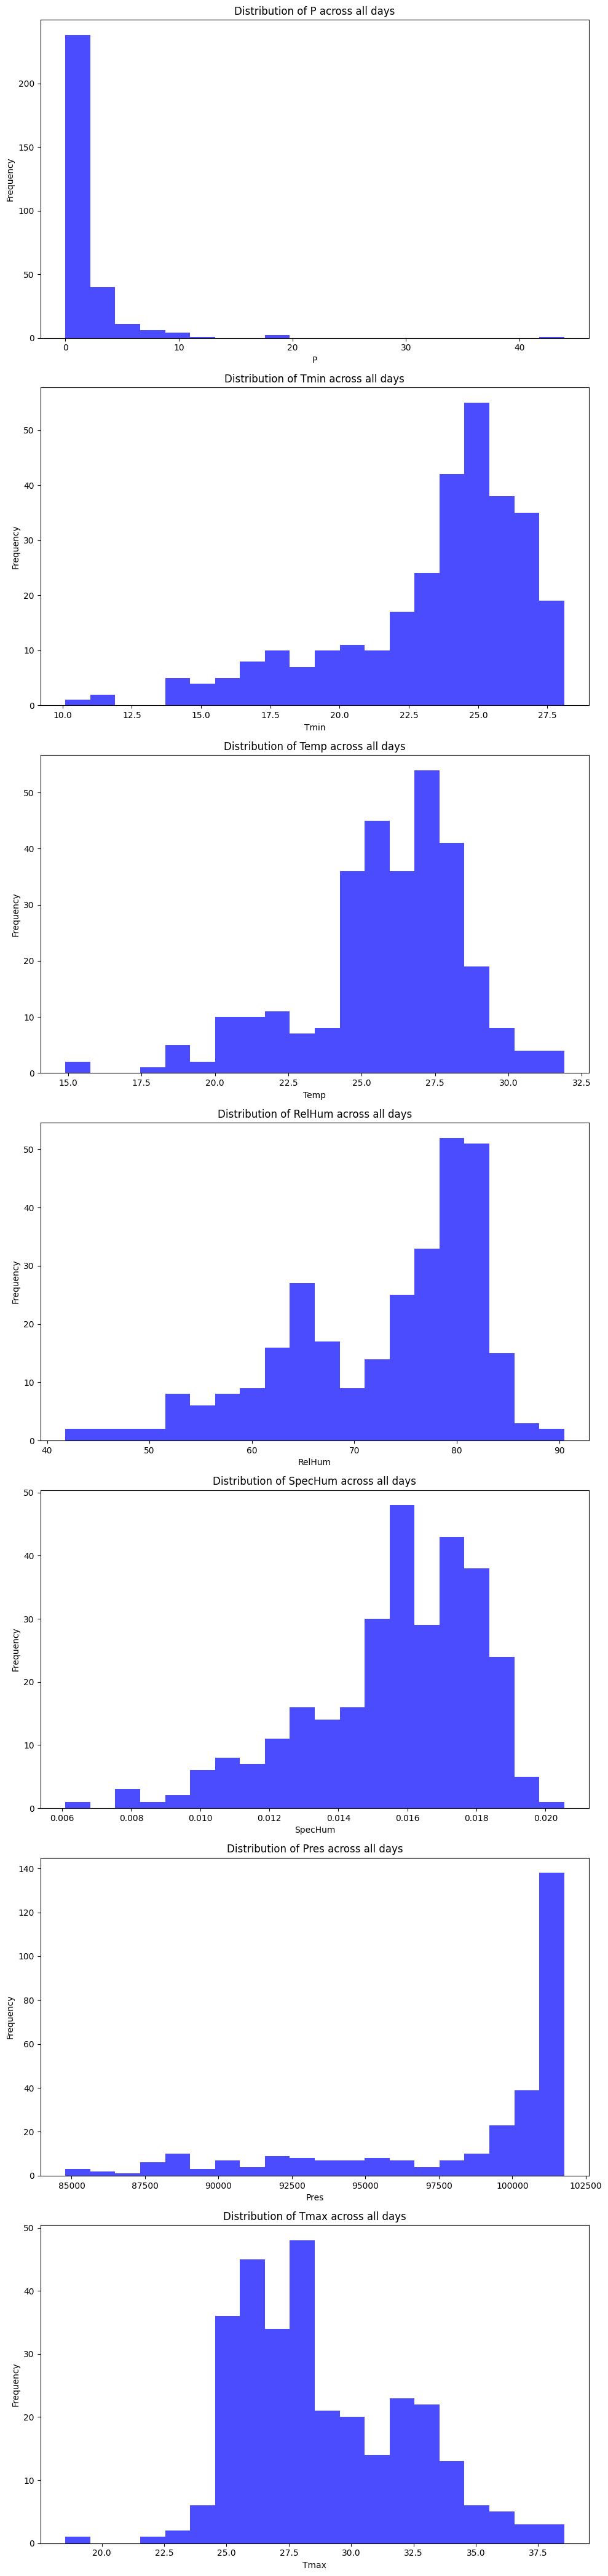

In [19]:
import matplotlib.pyplot as plt

# Define the variables to plot
variables_to_plot = ['P', 'Tmin', 'Temp', 'RelHum', 'SpecHum', 'Pres', 'Tmax']

# Aggregate the data across the 14 columns for each variable
aggregated_data = {}
for var in variables_to_plot:
    aggregated_data[var] = points_inside_polygon[[f'{var}_{i}' for i in range(1, 15)]].mean(axis=1)

# Plotting
fig, axs = plt.subplots(len(variables_to_plot), 1, figsize=(10, 6 * len(variables_to_plot)))
for i, var in enumerate(variables_to_plot):
    ax = axs[i]
    ax.hist(aggregated_data[var], bins=20, alpha=0.7, color='blue')
    ax.set_title(f'Distribution of {var} across all days')
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [20]:
points_inside_polygon.to_csv('boletus_spain_negative.csv', index=False)